In [1]:
# %pip install rdkit-pypi
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
import unittest
import numpy as np
import matplotlib.pyplot as plt
import moleculegraph
from moleculegraph.molecule_utils import *
import networkx as nx

[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2.]
f_p , self.f[f_p] [ 2 14 16] [ 2. -5. -6.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
fin branches [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


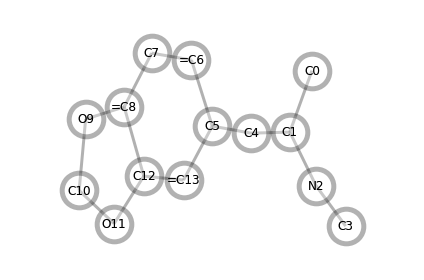

[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]


In [13]:
def get_graphstring(bond_list, names):
    graph = graph_from_bonds(bond_list)
    idx = 0

    main_path  = get_longest_path(graph,source=idx)

    return get_graphstring_set_main(bond_list, names, main_path)

def make_graph( stringlist ):
    """
    builds graph string from string list
    Args:
        stringlist:
            - list of strings containing names and 
            - add file format at the end ;)
    Returns:
        nothing        
    """        
    return "["+"][".join(stringlist)+"]"

def get_bond_types( atom_names, bond_list , special_bond_types=["="] ):
    atom_bond_types = np.array( [""]*len(atom_names) )
    clean_atom_names = atom_names.copy()
    for i,atom_name in enumerate(atom_names):
        for special_bond_type in special_bond_types:
            if special_bond_type in atom_name:
                clean_atom_names[i] = atom_name.replace(special_bond_type,"")
                atom_bond_types[i]  = special_bond_type
    bond_types = np.array( [""]*len( bond_list) )
    for i in np.squeeze( np.where( atom_bond_types != "" ) ):
        loc = np.max(np.where( i == np.squeeze(bond_list[:,1])  ) )
        bond_types[loc] = atom_bond_types[i]                
                
    return clean_atom_names, bond_types

def get_graphstring_set_main(graph, bond_list, names, main_path, 
                             bond_types=[] ):
    """
    generates a graphstring from a bond list and atom names
    uses the longest path from source to an end as main path
    
    Args:  
        graph:
            - networkx graph object  
        bond_list: 
            - np.array, bond list           
        names: 
            - np.array, atom names   
        main_path: 
            - np.array, main path to build graph from               
    Returns:
        str, graphstring to use with moleculegraph          
    """
    funs       = np.zeros(main_path.shape)
    fun_ranges = np.zeros(main_path.shape)

    main_path_bond_list = bond_list_from_simple_path(main_path)
    remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)
    
    while True:
        subgraph = graph_from_bonds(remaining_bonds)

        idx = get_next_index(main_path,remaining_bonds)

        subpath = get_longest_path(subgraph, source=idx)
        subpath_bond_list = bond_list_from_simple_path(subpath)
        match = np.intersect1d(main_path, subpath)

        if len(match)==2 and len(subpath)==2:
            print("ring")
            subpath = get_shortest_nontrivial_path(graph,match[0], match[1])
            i = np.squeeze( np.where(main_path == match[0]) )
            j = np.squeeze( np.where(main_path == match[1]) )
            iinsert = np.max( (i,j) )+1

            main_path  = np.insert( main_path, iinsert, [-1] )
            fun_ranges = np.insert( fun_ranges, iinsert, [len(subpath)] )
            funs       = np.insert( funs, iinsert, [-1] )        

        elif len(match)==1:
            print("branch")
            i = np.squeeze(match)
            if subpath[0] != i:
                subpath = subpath[::-1]
            subpath = subpath[1:]

            subfuns       = np.concatenate( [ [1], np.zeros(subpath.shape) ])
            subfun_ranges = np.concatenate( [ [len(subpath)], np.zeros(subpath.shape)  ])      
            subpath       = np.concatenate( [ [-1], subpath ])  

            iinsert = np.squeeze( np.where(main_path == i) )+1

            main_path  = np.insert( main_path, iinsert, subpath )
            fun_ranges = np.insert( fun_ranges, iinsert, subfun_ranges )
            funs       = np.insert( funs, iinsert, subfuns )

        else:
            print("ERROR")
            return None, None

        main_path_bond_list = np.concatenate( [main_path_bond_list, subpath_bond_list] )    
        remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)
        if len(remaining_bonds) == 0:
            break
    
    if "".join(bond_types) == "dff":
        dummy = main_path_bond_list.flatten()
        _, idx = np.unique( dummy, return_index=True)
        atom_nos = dummy[np.sort(idx)]        
        atom_names = names[atom_nos]
        for bond, bond_type in zip( bond_list, bond_types):
            p0 = np.squeeze( np.where( atom_nos==bond[0] ) )
            p1 = np.squeeze( np.where( atom_nos==bond[1] ) )
            dummy = [p0,p1]
            pp  = bond[ np.argmax( dummy ) ]
 
            names[pp] = bond_type+names[pp]
    
    molecule_list = []
    for i, (fun,rang) in zip( main_path, zip( funs, fun_ranges ) ):
        if fun == 0:
            molecule_list.append( names[i] )
        elif fun == 1:
            molecule_list.append( "b"+str( int(rang) ) ) 
        elif fun == -1:
            molecule_list.append( "r"+str( int(rang) ) )    

    molstring = "["+ "][".join(molecule_list) +"]"        
                    
    return molstring, main_path_bond_list



molstring = "[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]"

molecule = moleculegraph.molecule(molstring)
molecule.visualize()
print(molstring)

In [14]:
ends = np.concatenate( [molecule.branch_end_numbers, molecule.ring_close_numbers, molecule.ring_root_numbers] ).astype(int)


0 C0
branch
ring
ring
[C0][C1][b2][N2][C3][C4][C5][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
f_p , self.f[f_p] [ 2 13 16] [ 2. -5. -6.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
fin branches [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


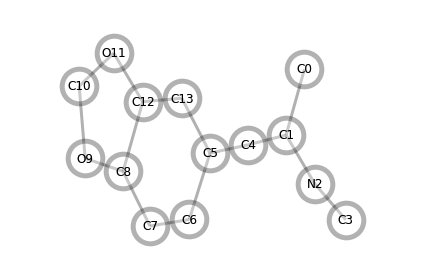

NEXT


3 C3
branch
ring
ring
[C3][N2][C1][b1][C0][C4][C5][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
f_p , self.f[f_p] [ 3 13 16] [ 1. -5. -6.]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2.]
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
fin branches [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


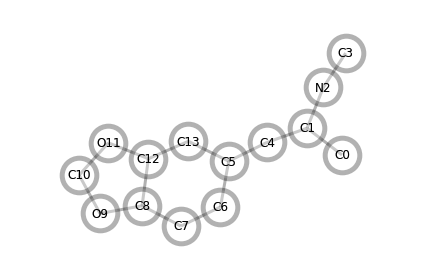

NEXT


12 C12
ERROR
NEXT


13 =C13
ring
branch
ring
[C13][C12][O11][C10][O9][C8][r5][C7][C6][C5][r6][C4][C1][b1][C0][N2][C3]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2. 2. 0. 0.]
f_p , self.f[f_p] [ 6 10 13] [-5. -6.  1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2. 2. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 2. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0.]
fin branches [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0.]


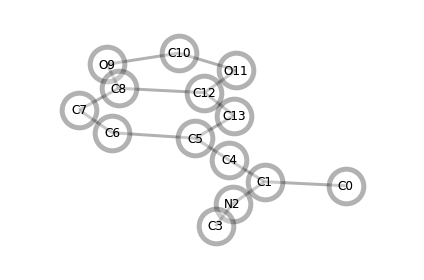

NEXT


8 =C8
ERROR
NEXT


5 C5
ring
branch
ring
branch
[C5][b4][C4][C1][b1][C0][N2][C3][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]
[0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3.]
f_p , self.f[f_p] [ 1  4 14 17] [ 4.  1. -5. -6.]
[0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3.]
[0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3.]
[0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3.]
[0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]
fin branches [0. 1. 1. 1. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


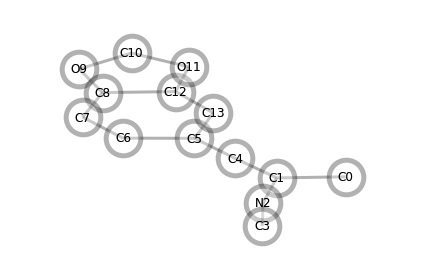

NEXT




In [15]:
"""

=C6, C5: branch close on start should not work

"""

graph = graph_from_bonds(molecule.bond_list)
for end in ends:
    print(end, molecule.atom_names[end])
    main_path_dummy  = get_longest_path(graph,source=end)
    clean_atom_names, bond_types = get_bond_types( molecule.atom_names, molecule.bond_list, special_bond_types=["="]  )
    molstring_dummy, main_path_bond_list = get_graphstring_set_main(graph, molecule.bond_list, clean_atom_names, 
                                               main_path_dummy, bond_types)
    if molstring_dummy:
        print(molstring_dummy)
        molecule_dummy = moleculegraph.molecule(molstring_dummy)
        molecule_dummy.visualize()
    print("NEXT\n\n")

In [5]:
clean_atom_names, molecule.atom_names

(array(['C0', '=C1', 'N2', 'C3', 'C4', 'C5', 'C6', '=C7', '=C8', 'O9',
        'C10', 'O11', 'C12', 'C13'], dtype='<U4'),
 array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', '=C6', 'C7', '=C8', 'O9',
        'C10', 'O11', 'C12', '=C13'], dtype='<U4'))

In [6]:
"=C6".replace("=","")

'C6'